In [26]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import argparse
import pickle
from PIL import Image
import os

In [27]:
from pipeline import callibrate_camera, get_perspective_transform_matrix, fit_polynomial, transform_image, \
    combined_gradient_color_threshold, combined_dir_color_threshold, dir_threshold, convert_to_grayscale, \
    sobel_mag_threshold, color_threshold, sobel_abs_threshold

In [28]:
# Read mtx and dist from disk to avoid recomputation every time.
pickle_file_name = 'camera_cal.pkl'
with open(pickle_file_name, 'rb') as f:
    pickle_dict = pickle.load(f)
    mtx = pickle_dict['mtx']
    dist = pickle_dict['dist']

In [29]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def visualize_calibration(file_name, mtx=mtx, dist=dist):
    img = mpimg.imread(file_name)
    undist = undistort(img, mtx, dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=30)

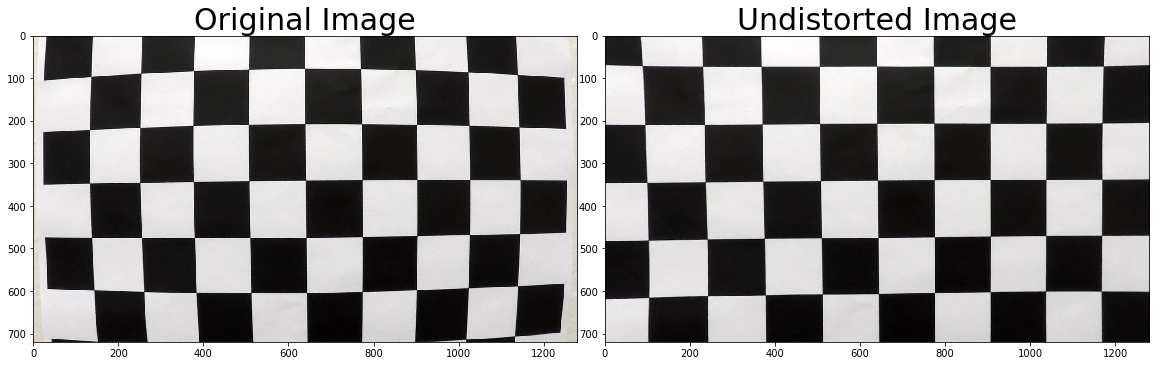

In [30]:
# Visualize calibrations on checker board.
visualize_calibration('./camera_cal/calibration1.jpg')

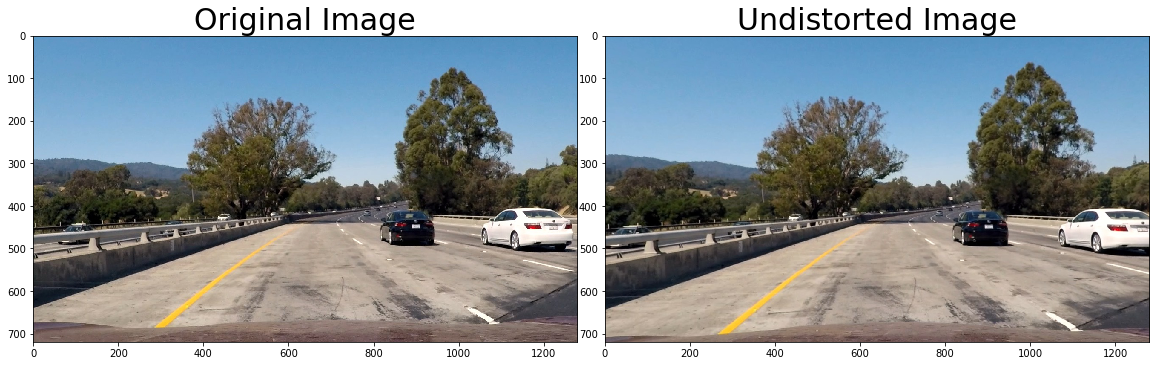

In [31]:
# Visualize calibrations on lanes.
visualize_calibration('./test_images/test1.jpg')

In [32]:
# Compute the perspective transform matrix.
src=np.float32([
    [576.04, 464.487], [707.079, 464.487],
    [268.552, 675.317], [1034.03, 675.317]]
)
w = 1280
margin = 200
dst=np.float32([
    [margin, 0],
    [w - margin, 0],
    [margin, 675.317],
    [w - margin, 675.317],
])
perspective_transform_matrix = get_perspective_transform_matrix(mtx, dist, src_points=src, dst_points=dst)

In [33]:
def undistort_unwarp(file_name, mtx, dist, perspective_transform_matrix):
    img = mpimg.imread(file_name)
    undist = undistort(img, mtx, dist)
    height, width = undist.shape[:2]
    unwarp = cv2.warpPerspective(
        undist, perspective_transform_matrix, (width, height),
        flags=cv2.INTER_LINEAR
    )
    return undist, unwarp


def visualize_unwarp(undist, unwarp, src):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(undist)
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
    ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.set_ylim([undist.shape[0],0])
    ax1.set_xlim([0,undist.shape[1]])
    ax1.set_title('Undistorted Image', fontsize=30)
    ax2.imshow(unwarp)
    ax2.set_title('Unwarped Image', fontsize=30)
    
    
def undist_unwarp_visualize(file_name, mtx, dist, perspective_transform_matrix, src):
    undist, unwarp = undistort_unwarp(file_name, mtx, dist, perspective_transform_matrix)
    visualize_unwarp(undist, unwarp, src)

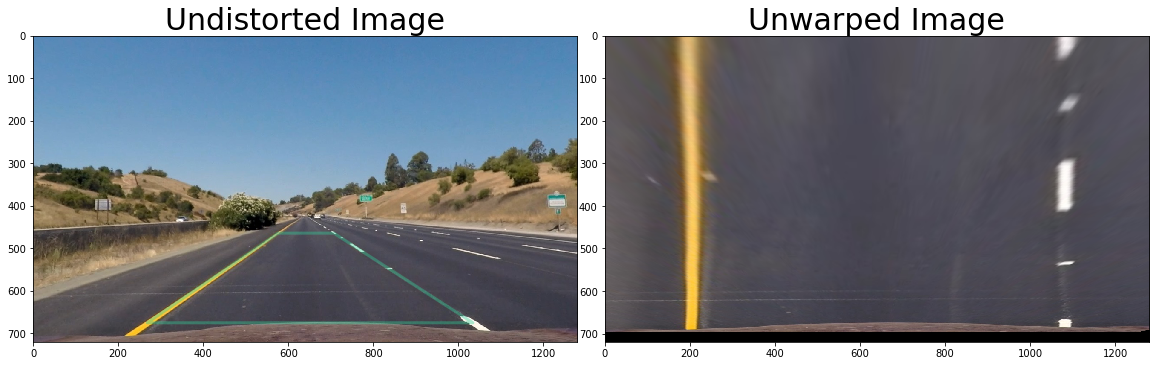

In [34]:
# Visualize unwarp
undist_unwarp_visualize('./test_images/straight_lines1.jpg', mtx, dist, perspective_transform_matrix, src)

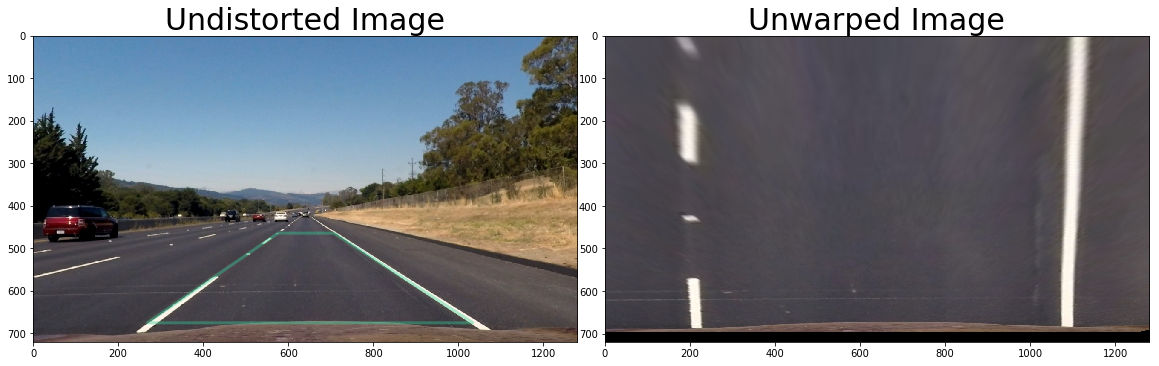

In [35]:
undist_unwarp_visualize('./test_images/straight_lines2.jpg', mtx, dist, perspective_transform_matrix, src)

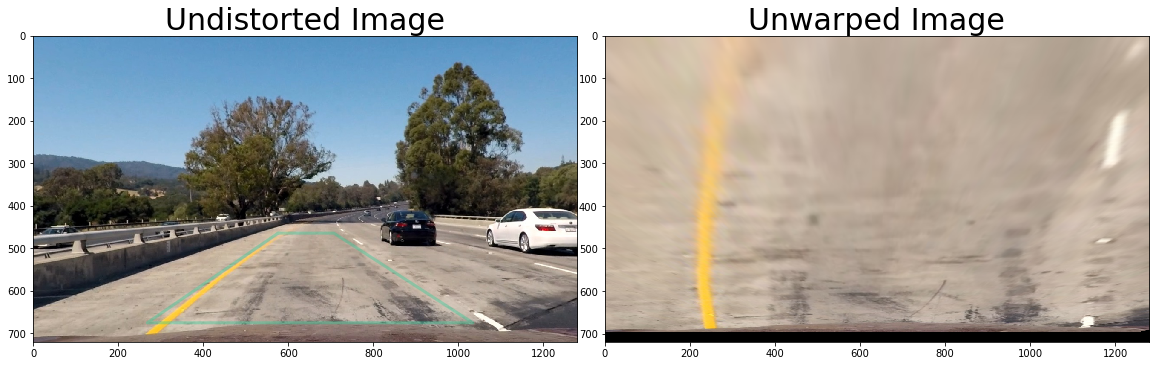

In [36]:
undist_unwarp_visualize('./test_images/test1.jpg', mtx, dist, perspective_transform_matrix, src)

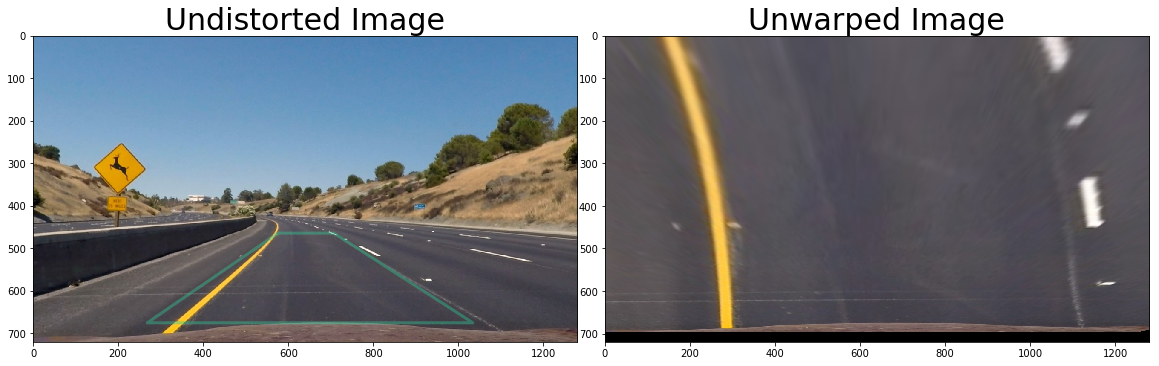

In [37]:
undist_unwarp_visualize('./test_images/test2.jpg', mtx, dist, perspective_transform_matrix, src)

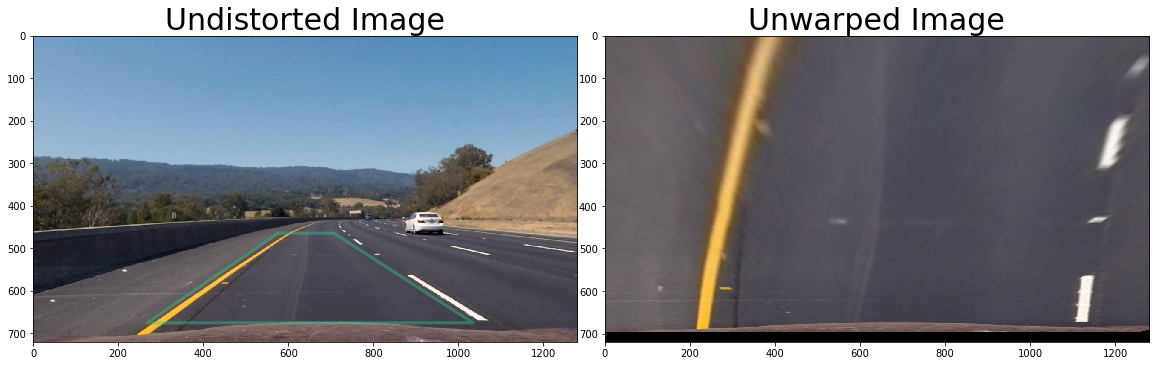

In [38]:
undist_unwarp_visualize('./test_images/test3.jpg', mtx, dist, perspective_transform_matrix, src)

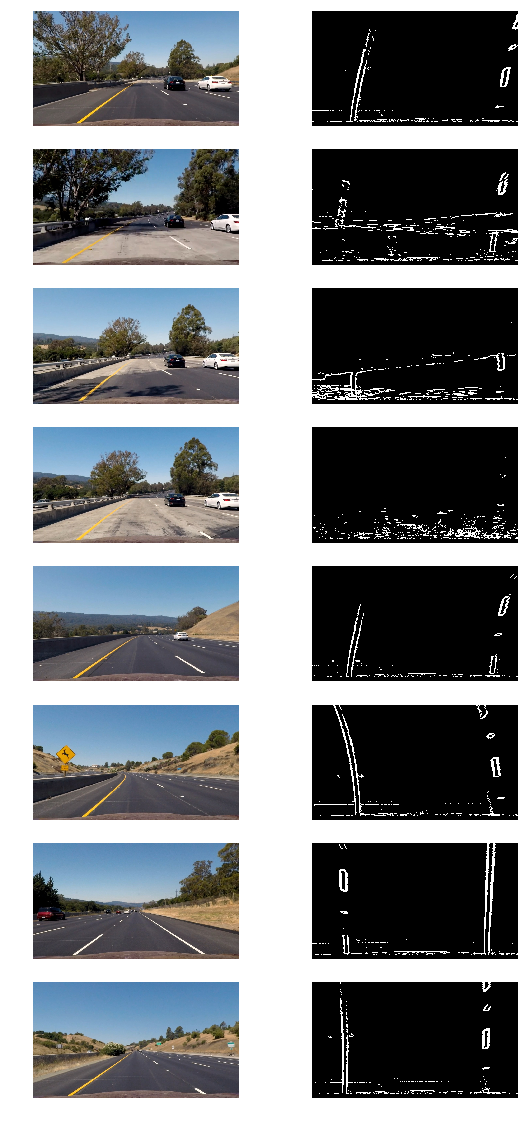

In [39]:
# Visualize magnitute threshold
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    undist, unwarp = undistort_unwarp(image, mtx, dist, perspective_transform_matrix)
    thresholded = sobel_mag_threshold(unwarp, mag_thresh=(15, 255))
    axs[i].imshow(undist)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(thresholded, cmap='gray')
    axs[i].axis('off')
    i += 1

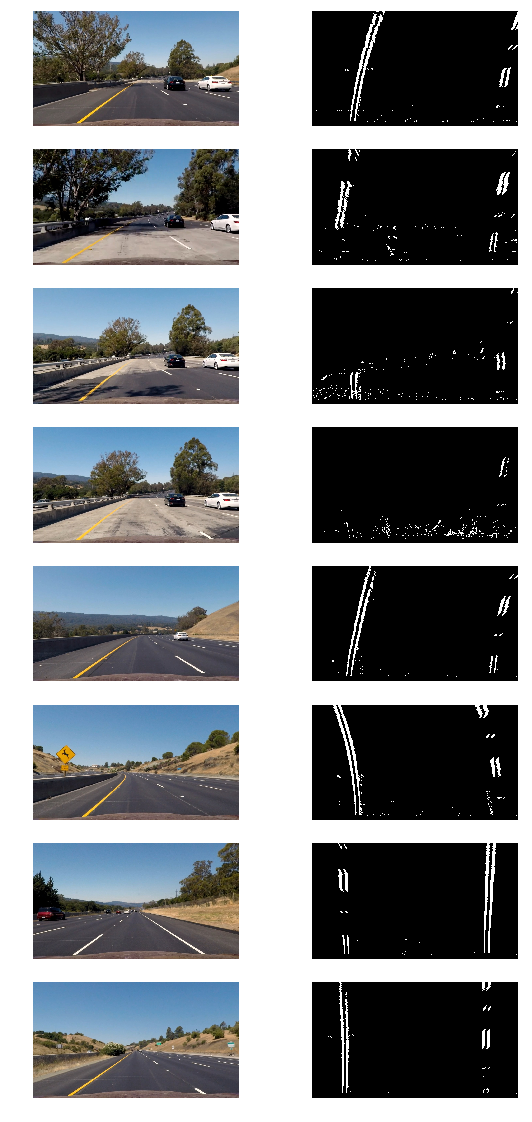

In [40]:
# Visualize abs x threshold
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    undist, unwarp = undistort_unwarp(image, mtx, dist, perspective_transform_matrix)
    thresholded = sobel_abs_threshold(unwarp, thresh=(20, 255))
    axs[i].imshow(undist)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(thresholded, cmap='gray')
    axs[i].axis('off')
    i += 1

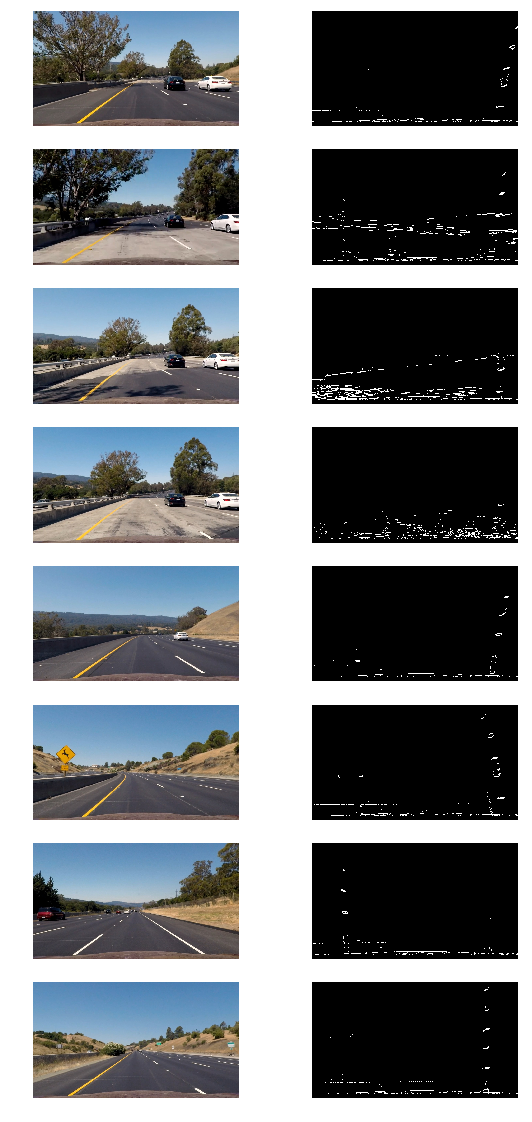

In [41]:
# Visualize abs 'y' threshold
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    undist, unwarp = undistort_unwarp(image, mtx, dist, perspective_transform_matrix)
    thresholded = sobel_abs_threshold(unwarp, orient='y', thresh=(20, 255))
    axs[i].imshow(undist)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(thresholded, cmap='gray')
    axs[i].axis('off')
    i += 1

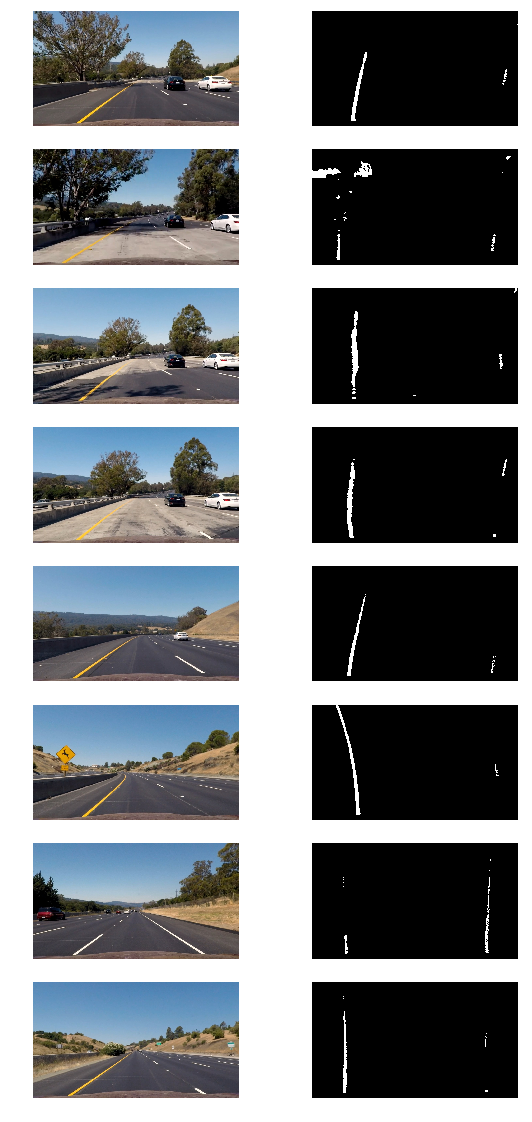

In [43]:
# Visualize color threshold
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    undist, unwarp = undistort_unwarp(image, mtx, dist, perspective_transform_matrix)
    thresholded = color_threshold(unwarp, thresh=(190, 255))
    axs[i].imshow(undist)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(thresholded, cmap='gray')
    axs[i].axis('off')
    i += 1

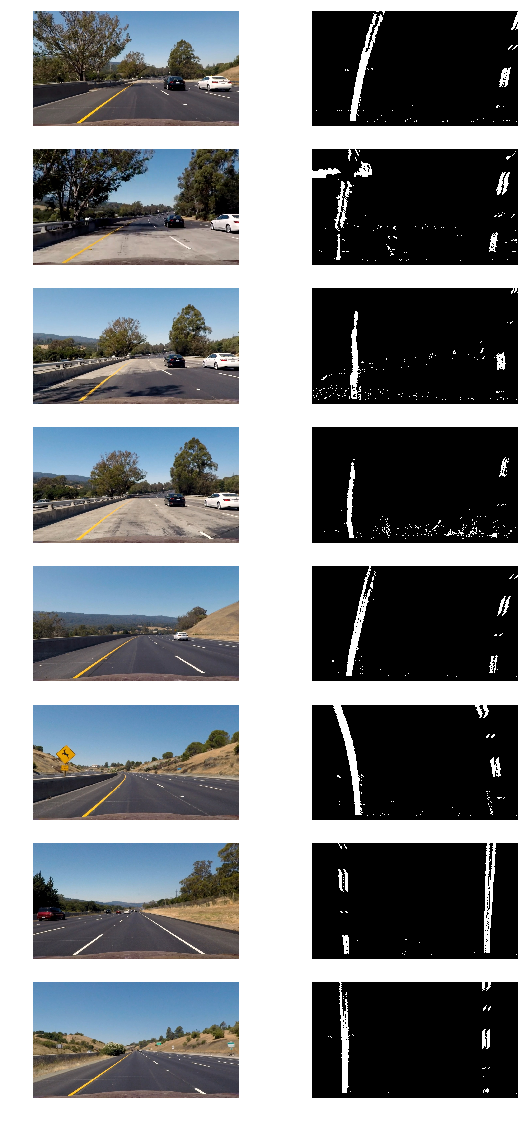

In [45]:
# Visualize combined_gradient_color_threshold
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    undist, unwarp = undistort_unwarp(image, mtx, dist, perspective_transform_matrix)
    thresholded = combined_gradient_color_threshold(unwarp, color_thresh=(190, 255), grad_x_thresh=(20, 255))
    axs[i].imshow(undist)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(thresholded, cmap='gray')
    axs[i].axis('off')
    i += 1



In [46]:
def dir_threshold2(img, sobel_kernel=11, thresh=( 0, np.pi/10)):
    # Grayscale
    gray = convert_to_grayscale(img)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.absolute(np.arctan2(np.absolute(sobely), np.absolute(sobelx)))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

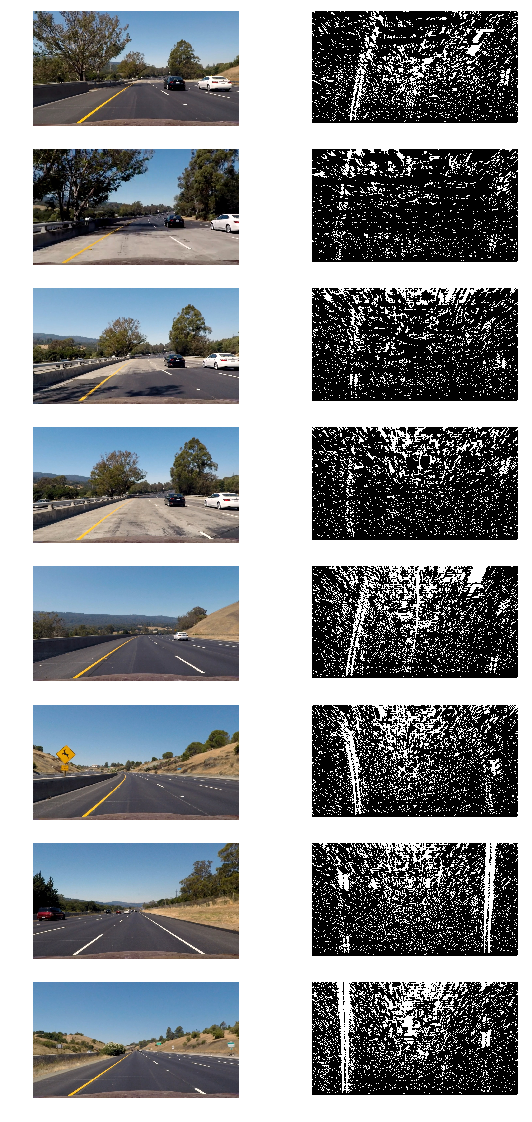

In [47]:
# Visualize direction threshold
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    undist, unwarp = undistort_unwarp(image, mtx, dist, perspective_transform_matrix)
    thresholded = dir_threshold2(unwarp)
    axs[i].imshow(undist)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(thresholded, cmap='gray')
    axs[i].axis('off')
    i += 1


In [48]:
def combined_grad_dir_color_threshold(
    img, grad_x_thresh=(25, 255), color_thresh=(120, 255), dir_thresh=(0, np.pi/40)
):
    threshold_grad = sobel_abs_threshold(img, thresh=grad_x_thresh)
    threshold_color = color_threshold(img, thresh=color_thresh)    
    threshold_dir = dir_threshold(img, thresh=dir_thresh)
    combined_binary = np.zeros_like(threshold_dir)
    combined_binary[((threshold_grad == 1) | (threshold_color == 1)) & (threshold_dir == 1)] = 1
    return combined_binary

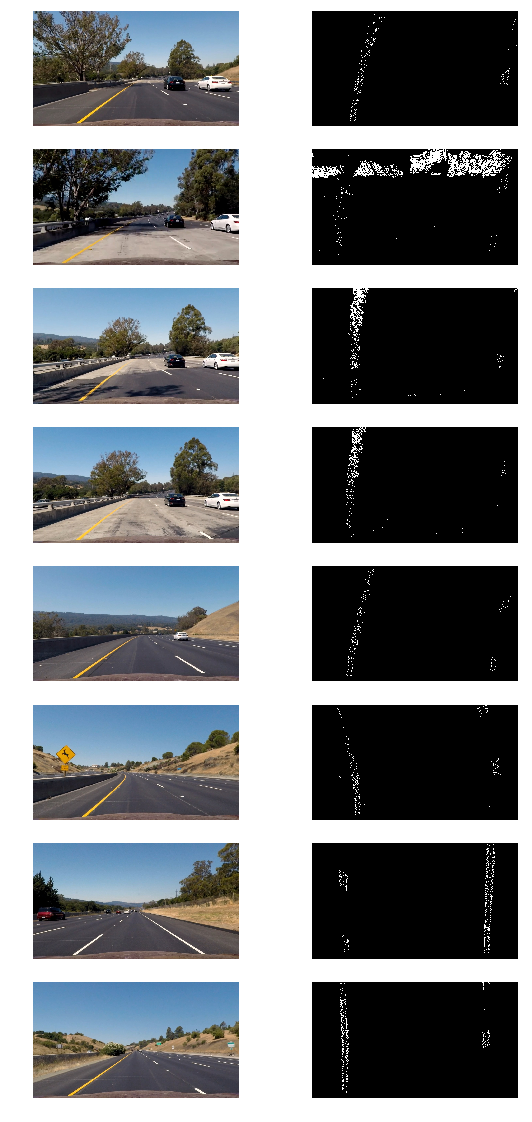

In [49]:
# Visualize combined_gradient_color_threshold
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    undist, unwarp = undistort_unwarp(image, mtx, dist, perspective_transform_matrix)
    thresholded = combined_grad_dir_color_threshold(unwarp)
    axs[i].imshow(undist)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(thresholded, cmap='gray')
    axs[i].axis('off')
    i += 1


In [50]:
from ipywidgets import interact, interactive, fixed


In [51]:
undist, unwarp = undistort_unwarp('test_images/straight_lines1.jpg', mtx, dist, perspective_transform_matrix)
def update(kernel_size, min_thresh, max_thresh):
    dir_threshold_img = dir_threshold2(unwarp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(dir_threshold_img, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,np.pi/10,0.01), 
                 max_thresh=(0,np.pi/10,0.01))


interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), FloatSlider(value…

<function __main__.update(kernel_size, min_thresh, max_thresh)>

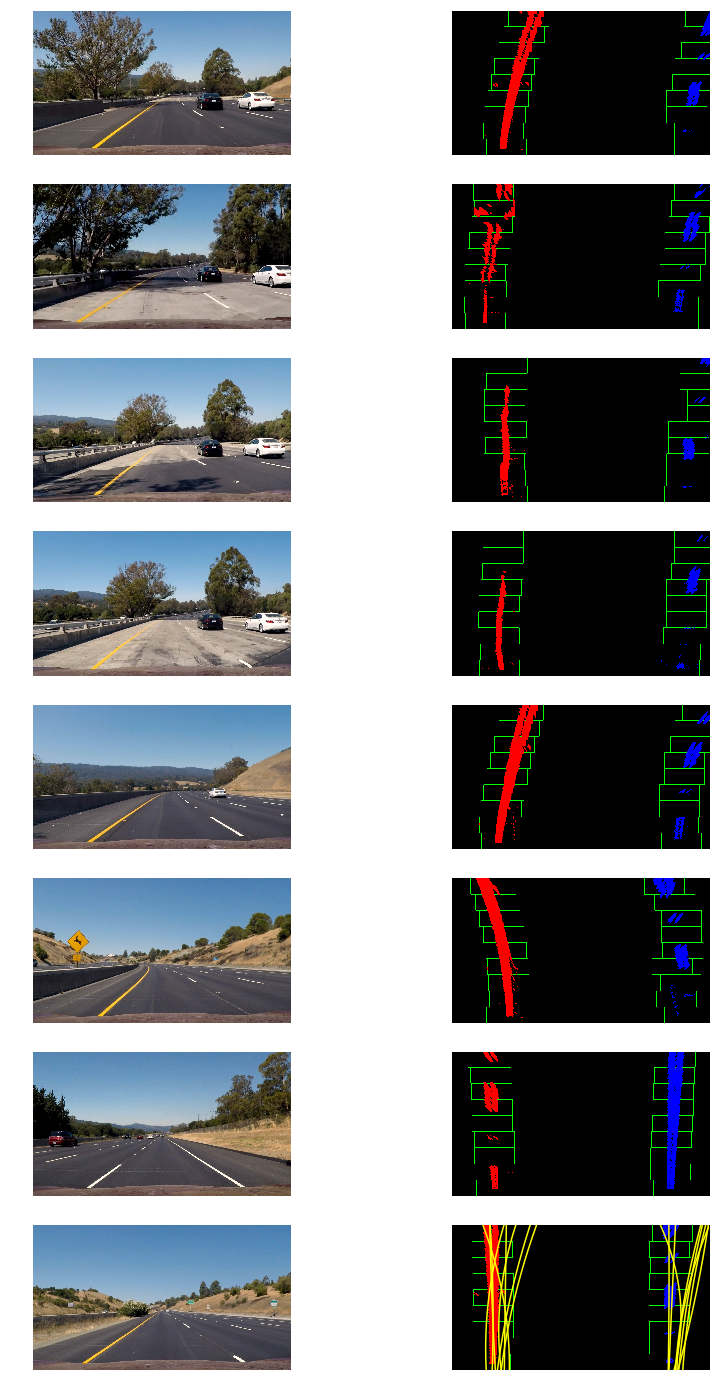

In [57]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(15, 25))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image_file in images:
    img, undist, threshold_binary, p_transformed, out_img = transform_image(
        image_file, mtx=mtx, dist=dist,
        p_transform_matrix=perspective_transform_matrix,
        color_threshold=(190, 255), grad_x_thresh=(20, 255)
    )
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(out_img, cmap='gray')
    axs[i].axis('off')
    i += 1

